In [2]:
#https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573
import torch
import numpy as np
import os
import sys
sys.path.append('../')
os.environ["CUDA_VISIBLE_DEVICES"]="5"
import torchvision
from voc import *
from coco import *
import torchvision.transforms as transforms
# from torchvision.models import resnet152, resnet101, resnet18, resnet34, resnet50
from tqdm import tqdm
import json
import pandas as pd
import matplotlib.pyplot as plt
from config import seed_everything
seed_everything(0)
from models import *
from torchsummary import summary

import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, utils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
from PIL import Image
import json
%matplotlib inline

/home/seongha/anaconda3/envs/MGSSL/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
image_normalization_mean = [0.485, 0.456, 0.406]
image_normalization_std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=image_normalization_mean,
                                             std=image_normalization_std)
transform = transforms.Compose([
                # MultiScaleCrop(self.state['image_size'], scales=(1.0, 0.875, 0.75, 0.66, 0.5), max_distort=2),
                # transforms.RandomHorizontalFlip(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                normalize,
            ])

In [4]:

from models import *
from backbones.config import config
print(config)
for k, v in config.items():
  print("{} : {}".format(k, v))

m_li = [base_resnet50(model_path=config['resnet50'], num_classes=80, pretrained=True),\
   base_vit(config['vit'], 80, image_size=224, pretrained=True),\
      base_swin(config['swin'], 80, image_size=224, pretrained=True),\
         base_convnext(config['convnext'], 80, image_size=224, pretrained=True), \
           base_mlpmixer(config['mlpmixer'], num_classes=80, image_size=224, pretrained=True)]
# m_li2 = [BaseResnet(m_li[0], 80)]
p_li = ['/home/seongha/LT-ML/checkpoint/coco/coco_LT(0)_label_cnt_in21k-4-4-0_resnet50_base_best.pth.tar', \
  '/home/seongha/LT-ML/checkpoint/coco/coco_LT(0)_label_cnt_in21k-4-4-0_vit_base_best.pth.tar', \
    '/home/seongha/LT-ML/checkpoint/coco/coco_LT(0)_label_cnt_in22k-4-4-0_swin_base_best.pth.tar'\
  '/home/seongha/LT-ML/checkpoint/coco/coco_LT(0)_label_cnt_in22k-4-4-0_convnext_base_best.pth.tar',\
      '/home/seongha/LT-ML/checkpoint/coco/coco_LT(0)_label_cnt_in21k-4-4-0_mlpmixer_base_best.pth.tar' ,\
  ]

def get_model(index):
  path = p_li[index]
  model = m_li[index]
  di = torch.load(path)
  print(di['best_score'])
  print(di.keys())
  model.load_state_dict(di['state_dict'])
  return model

model = get_model(0)
print(model)
# summary(model.features, (3,224,224), None)

{'resnet50': 'resnetv2_50x3_bitm_in21k', 'vit': 'vit_base_patch16_224_in21k', 'vit-hybrid': 'vit_base_r50_s16_224_in21k', 'swin': 'swin_base_patch4_window7_224_in22k', 'convnext': 'convnext_base_in22k', 'mlpmixer': 'mixer_b16_224_in21k'}
resnet50 : resnetv2_50x3_bitm_in21k
vit : vit_base_patch16_224_in21k
vit-hybrid : vit_base_r50_s16_224_in21k
swin : swin_base_patch4_window7_224_in22k
convnext : convnext_base_in22k
mlpmixer : mixer_b16_224_in21k
Linear(in_features=768, out_features=80, bias=True)


/home/seongha/anaconda3/envs/MGSSL/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{'mAP': tensor(75.3806), 'OF1': 0.7281215292811023, 'CF1': 0.706165627126658}
dict_keys(['epoch', 'arch', 'state_dict', 'best_score'])
BaseResnetV2(
  (features): Sequential(
    (0): Sequential(
      (conv): StdConv2d(3, 192, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (pad): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): ResNetStage(
        (blocks): Sequential(
          (0): PreActBottleneck(
            (downsample): DownsampleConv(
              (conv): StdConv2d(192, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (norm): Identity()
            )
            (norm1): GroupNormAct(
              32, 192, eps=1e-05, affine=True
              (drop): Identity()
              (act): ReLU(inplace=True)
            )
            (conv1): StdConv2d(192, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
            

In [5]:
import timm
from backbones.config import config
model = timm.create_model(config['swin'], num_classes=80, pretrained=True)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [5]:
from pytorch_tools.modules.weight_standartization import WS_Conv2d as StdConv2d

In [7]:
for name, module in model.named_modules():
  print(name, "--> ")

 --> 
patch_embed --> 
patch_embed.proj --> 
patch_embed.norm --> 
pos_drop --> 
layers --> 
layers.0 --> 
layers.0.blocks --> 
layers.0.blocks.0 --> 
layers.0.blocks.0.norm1 --> 
layers.0.blocks.0.attn --> 
layers.0.blocks.0.attn.qkv --> 
layers.0.blocks.0.attn.attn_drop --> 
layers.0.blocks.0.attn.proj --> 
layers.0.blocks.0.attn.proj_drop --> 
layers.0.blocks.0.attn.softmax --> 
layers.0.blocks.0.drop_path --> 
layers.0.blocks.0.norm2 --> 
layers.0.blocks.0.mlp --> 
layers.0.blocks.0.mlp.fc1 --> 
layers.0.blocks.0.mlp.act --> 
layers.0.blocks.0.mlp.drop1 --> 
layers.0.blocks.0.mlp.fc2 --> 
layers.0.blocks.0.mlp.drop2 --> 
layers.0.blocks.1 --> 
layers.0.blocks.1.norm1 --> 
layers.0.blocks.1.attn --> 
layers.0.blocks.1.attn.qkv --> 
layers.0.blocks.1.attn.attn_drop --> 
layers.0.blocks.1.attn.proj --> 
layers.0.blocks.1.attn.proj_drop --> 
layers.0.blocks.1.attn.softmax --> 
layers.0.blocks.1.drop_path --> 
layers.0.blocks.1.norm2 --> 
layers.0.blocks.1.mlp --> 
layers.0.blocks.1.mlp

In [8]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = [model.patch_embed, model.pos_drop]
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0

for i in range(len(model.layers)):
        counter+=1
        # model_weights.append(model.layers[i].weight)
        conv_layers.append(model.layers[i])

print(f"Total convolution layers: {counter}")

Total convolution layers: 4


Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])


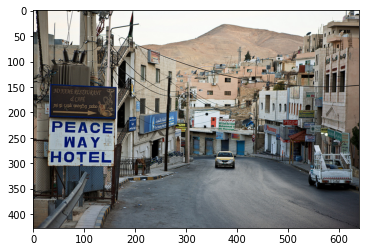

In [9]:
img_id = '/home/seongha/LT-ML/data/coco/data/train2014/COCO_train2014_000000000094.jpg'
image = Image.open(img_id)
plt.imshow(image)
image = transform(image)


print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

In [10]:
outputs = []
names = []
for layer in conv_layers[0:]:
    layer = layer.to(device)
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

6
torch.Size([1, 3136, 128])
torch.Size([1, 3136, 128])
torch.Size([1, 784, 256])
torch.Size([1, 196, 512])
torch.Size([1, 49, 1024])
torch.Size([1, 49, 1024])


Now convert 3D tensor to 2D (if necessary), Sum the same element of every channel

In [14]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    # gray_scale = torch.sum(feature_map,0)
    # gray_scale = gray_scale / feature_map.shape[0]
    # processed.append(gray_scale.data.cpu().numpy())
    processed.append(feature_map.data.cpu().numpy())
for fm in processed:
    fm = fm.flatten()
    print(fm.shape)

(401408,)
(401408,)
(200704,)
(100352,)
(50176,)
(50176,)


LinAlgError: Last 2 dimensions of the array must be square

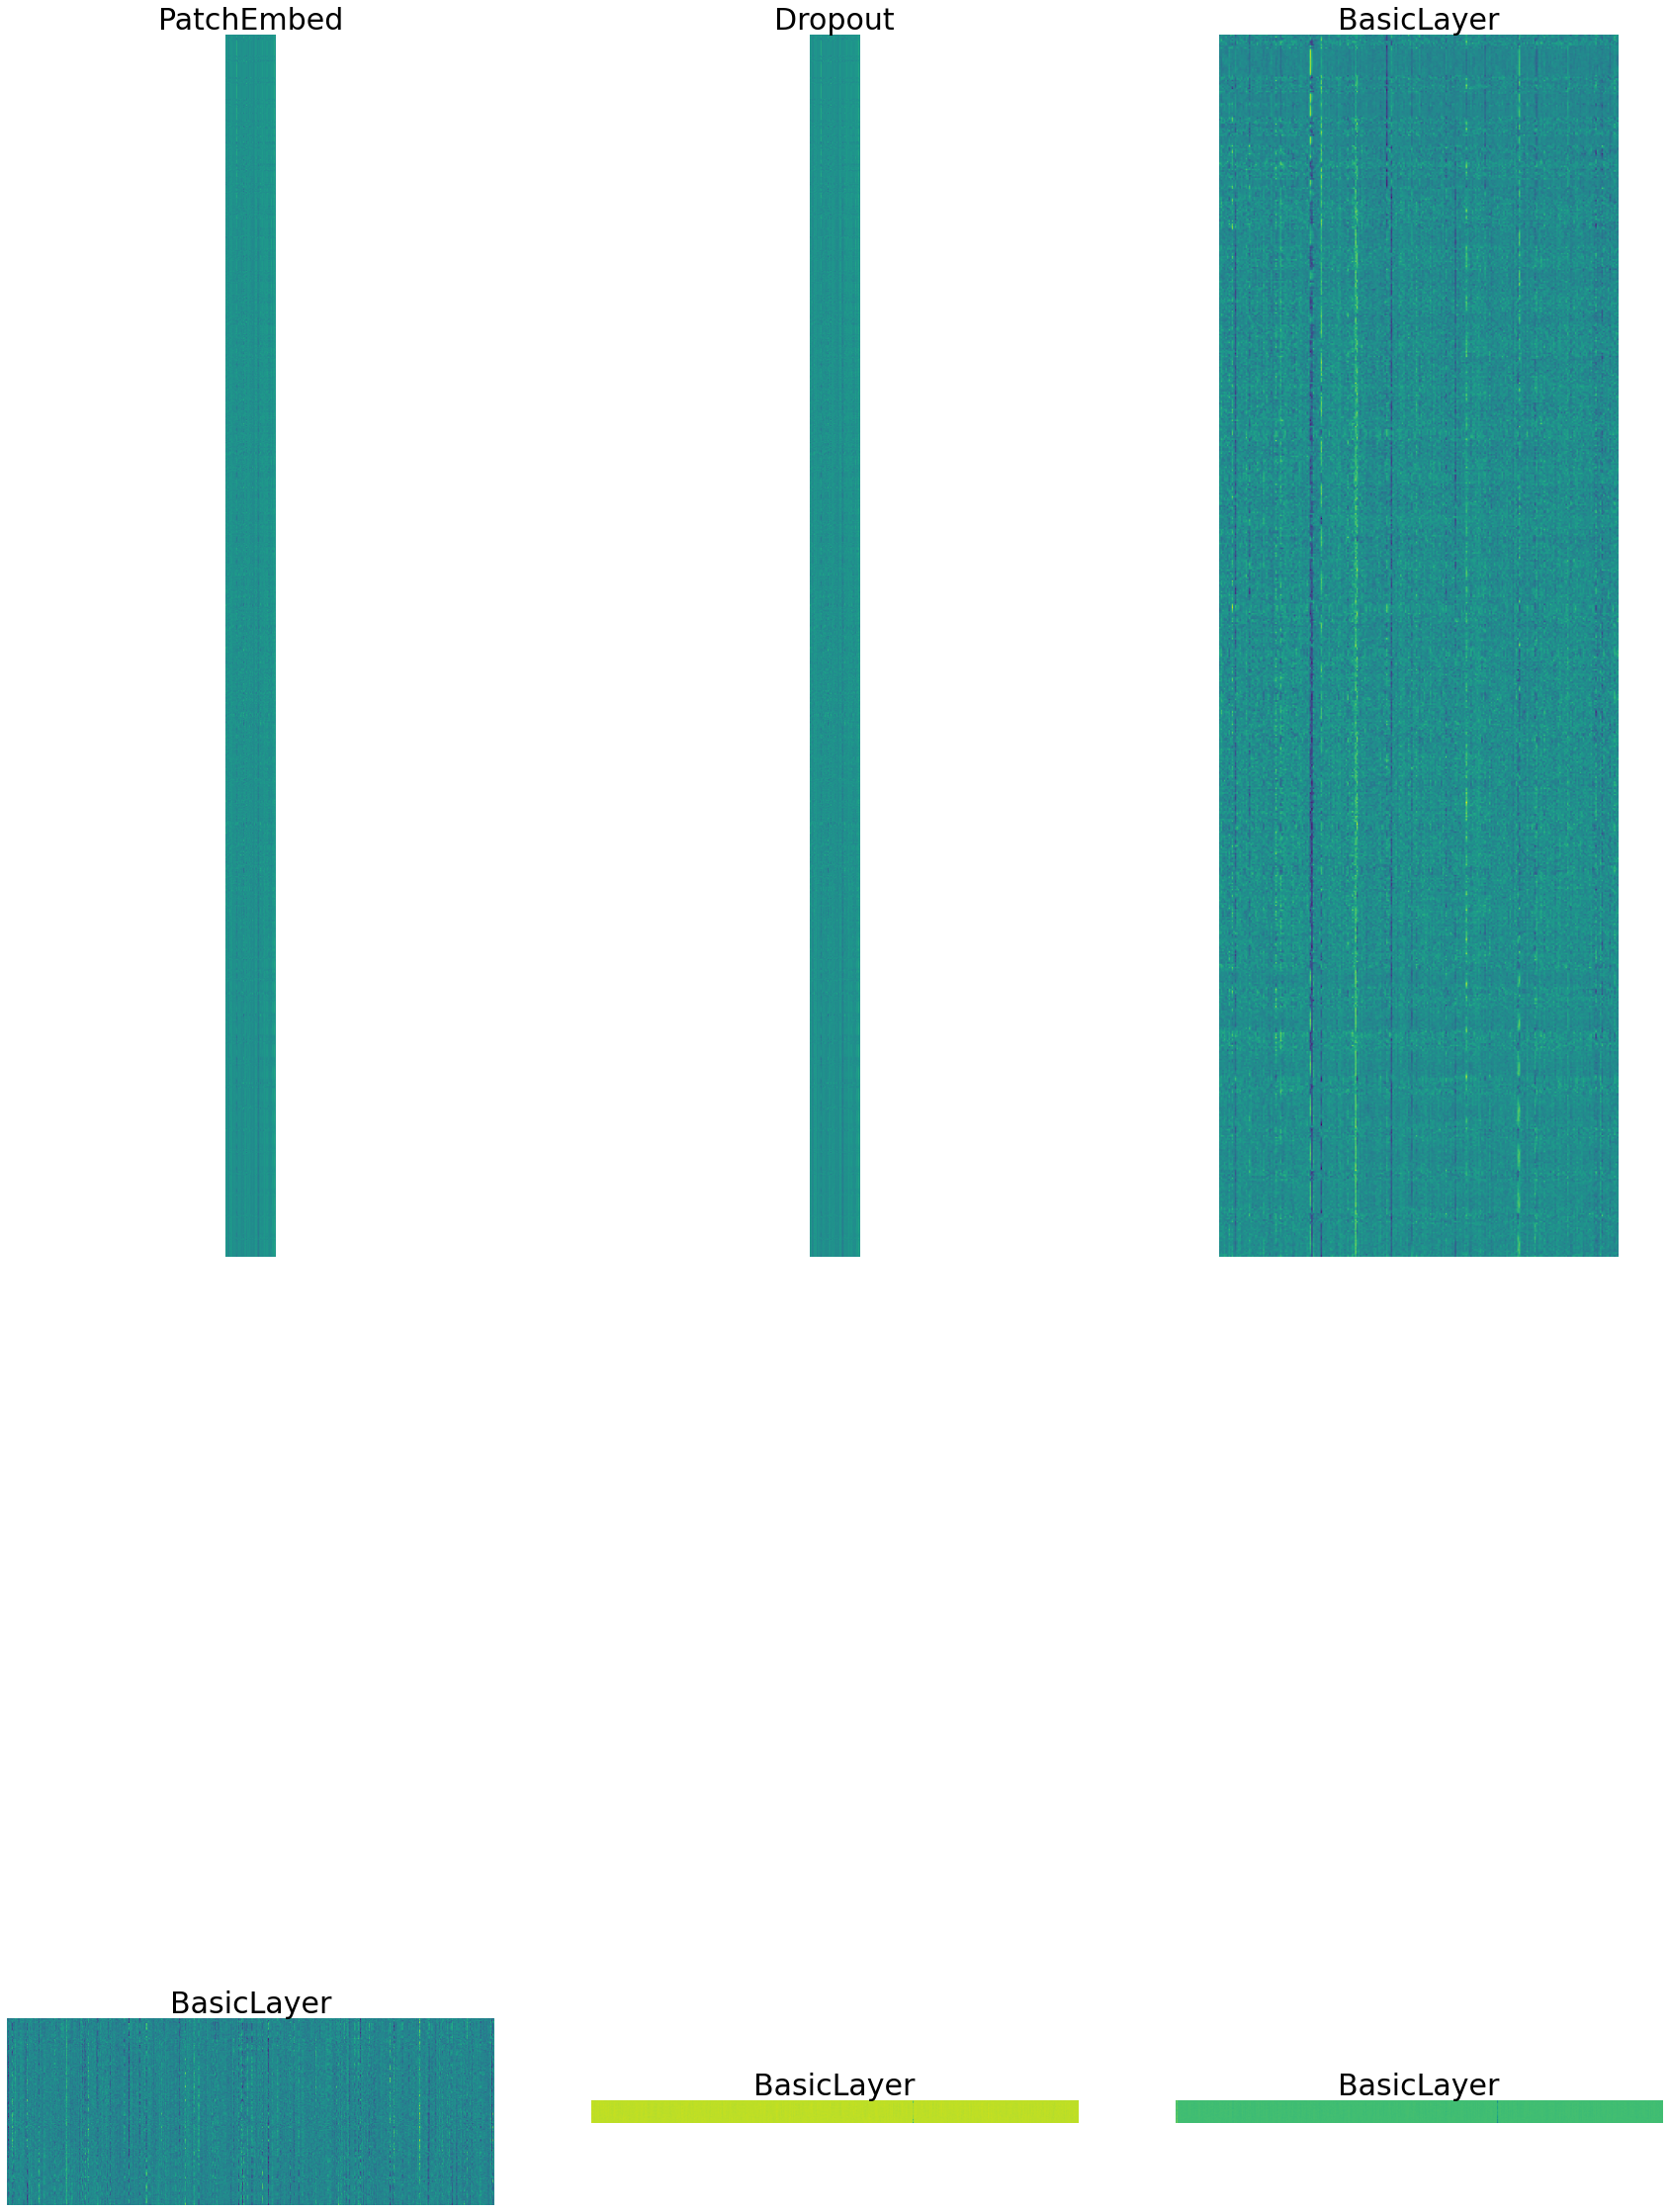

In [34]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(2, 3, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

In [36]:

sorted, indices = torch.sort(model(image), descending=True)
print(indices)


ValueError: not enough values to unpack (expected 4, got 3)